<a href="https://colab.research.google.com/github/gloria256/EXPERIMENTOS-ARTICULO-1/blob/master/Normal-250-64-CLASIFICADOR_BINARIO_DE_VACAS_Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASIFICADOR BINARIO DE VACAS USANDO LA RED: VGG16**







## **1. Librerías necesarias y descarga de 900 imágenes de carpetas en Drive.**

**Vacas-500:** Cotiene 500 imágenes de vacas
**Gallinas200:** Contiene 200 imágenes de gallinas
**Caballos200**: Contiene 200 imágenes de caballos

In [0]:
#IMPORTACION DE LIBRERIAS NECESARIAS
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from keras.applications.resnet import preprocess_input, decode_predictions
import sklearn

# ACCESO A GOOGLE DRIVE
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#ARCHIVO DE FUNCIONES
file_id = '1QTJIzZb4xL9_it6AF4qpz6KJGIpprIVD' 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('funciones_people.py') 
from funciones_people import roc_multiclass, roc_auc_mc

#ID DE LA CARPETA DONDE ESTAN LAS IMAGENES DE VACAS EN DRIVE
file_list = drive.ListFile({'q': "'1dcOoaMlNQnHSkG8fNfMJ6hFHrb_2Wl9F' in parents"}).GetList()

#ID DE LA CARPETA DONDE ESTAN LAS IMAGENES DE GALLINAS EN DRIVE
file_list2 = drive.ListFile({'q': "'1iZXyqw-N9K7VMHabPGur539KTbhJYBsF' in parents"}).GetList()

#ID DE LA CARPETA DONDE ESTAN LAS IMAGENES DE CABALLOS EN DRIVE
file_list3 = drive.ListFile({'q': "'16TYIXD8OdBLQdr9pjdACDLyCTeaB4J_i' in parents"}).GetList()

Using TensorFlow backend.


## **2. Definición de funciones a usar durante el desarrollo del clasificador Binario**

Se utilizan 2 funciones separadas para cambiar el tamaño de las imagenes de CIFAR10 y las descargadas de Drive, debido a la forma de lecttura.

In [0]:
#FUNCION PARA IMAGEN DE 224x224
def preproceso(image):
  resize_imagen = cv2.resize(image,(224,224), interpolation = cv2.INTER_AREA)
  #resize_imagen=tf.image.resize(image,[224,224])
  #final_imagen=preprocess_input(resize_imagen)
  return resize_imagen

#FUNCION PARA TAMAÑO(224x224x3)
def nuevo_tamaño(X):
  tam=len(X)
  matriz_imagen1=np.zeros([tam,224,224,3],dtype=np.uint8)
  for i in range(1,tam):
    ind=X.index[i-1]
    nombre=X.loc[ind,'titulo']
    imagen=cv2.imread(nombre)
    imagen=cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
    imagen=preproceso(imagen)
    for d in range(224):
      for c in range(0,3):
        matriz_imagen1[i-1][d][:,c]=imagen[d,:,c]
  return matriz_imagen1
  
#FUNCION DESCARGAR IMAGEN
def descargarImagen(file_list):
  titulo=[]
  c=0
  for f in file_list:
    fname = os.path.join(local_download_path, f['title'])
    titulo.append(fname)
    imagen = drive.CreateFile({'id': f['id']})
    imagen.GetContentFile(fname)
    print(c," ",end="")
    c=c+1
  return titulo

#CAMBIAR SCALA DE IMAGENES CIFAR10 A 224X224X3
def cambiar_scala_224x224(imagen):
  matriz_imagen1=np.zeros([len(imagen),224,224,3],dtype=np.uint8)
  for i in range(len(imagen)):
    img=imagen[i]
    scale_percent = 700 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    matriz_imagen1[i]=resized
    #for d in range(224):
     # for c in range(0,3):
     #   matriz_imagen1[i][d][:,c]=resized[d,:,c]
  return matriz_imagen1

## **3. Leer y descargar imagenes contenidas en las carpetas de DRIVE**

In [0]:
#ELEGIR DIRECTORIO LOCAL EN COLAB PARA ALMACENAR LOS DATOS
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

#### **A:** Descargar imágenes de drive y devolver unn array de los nombres de cada una, (**ver funcion:** descargarImagen(X)).




In [0]:
#LEO CADA IMAGEN CONTENIDA EN LA CARPETA DE VACAS Y LA DESCARGO CON EL id DE CADA UNA
titulo = descargarImagen(file_list)

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220  221  

In [0]:
#LEO CADA IMAGEN CONTENIDA EN LA CARPETA DE GALLINAS Y LA DESCARGO CON EL id DE CADA UNA
titulo2= descargarImagen(file_list2)

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  

In [0]:
#LEO CADA IMAGEN CONTENIDA EN LA CARPETA DE CABALLOS Y LA DESCARGO CON EL id DE CADA UNA
titulo3= descargarImagen(file_list3)

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  

#### **B:** Armar pandas de cada array hecho anterior (titulo,titulo2,titulo3) y unir cada panadas creado en uno solo (z).**texto en negrita**

In [0]:
#SE CONVIERTE CADA MATRIZ EN UN PANDAS
df = pd.DataFrame({"titulo": titulo})
df2 = pd.DataFrame({"titulo": titulo2})
df3 = pd.DataFrame({"titulo": titulo3})

#CONCATENAR EN UN SOLO PANDAS Y REVOLVER
z=pd.concat([df,df2,df3], axis=0, ignore_index=True)
print(len(z))

900


####**C:** A partir del pandas anterior(z), armar una matriz de 4 dimensiones(m,224x224x3). (**Ver funcion:** nuevo_tamaño(X))




In [0]:
Xtrain_z=nuevo_tamaño(z)

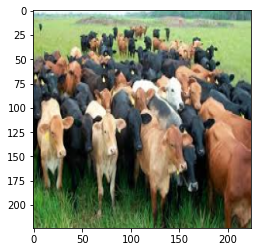

In [0]:
plt.imshow(Xtrain_z[0])

## **4. Descargar 600 imágenes del conjunto de Xtrain de CIFAR-10**

consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de prueba.

El conjunto de datos se divide en cinco lotes de entrenamiento y un lote de prueba, cada uno con 10000 imágenes. El lote de prueba contiene exactamente 1000 imágenes seleccionadas al azar de cada clase. 

$avión\hspace{1em}automóvil\hspace{1em}pájaro\hspace{1em}gato    
ciervo\hspace{1em}perro\hspace{1em}rana\hspace{1em}caballo\hspace{1em}
Embarcacion\hspace{1em}camión$

In [0]:
#CARGAR  IMAGENES DE XTRAIN DE CIFAR10 CON TENSOR
#Xtrain = tfds.load('cifar10', split='train', shuffle_files=True)
#data,info = tfds.load("cifar10",with_info=True, as_supervised=True)
#Xtrain,Xtest=data["train"],data["test"]
#info

#### **A:** Descargar de keras datasets CIFAR10 y seleccionar las primeras 600 imagenes del conjunto de **Train**




In [0]:
#IMPORTAR EL CONJUNTO DE DATOS CIFAR10 CON KERAS Y TOMAR LAS PRIMERAS 2000 IMAGENES
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train=x_train[0:600]
x_train.shape

170500096/170498071 [==============================] - 4s 0us/step


(600, 32, 32, 3)

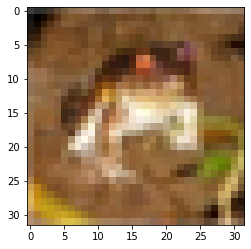

In [0]:
plt.imshow(x_train[0])

#### **B:** Cambiar tamaño de 32x32x3, a scala de: 224x224x3 (**Ver función:** cambiar_scala_224x224(X))




In [0]:
Xtrain_cifar10=cambiar_scala_224x224(x_train)
Xtrain_cifar10.shape

(600, 224, 224, 3)

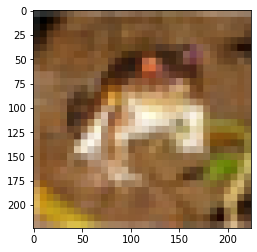

In [0]:
plt.imshow(Xtrain_cifar10[0])

## **5. Agrupar conjunto de datos, en uno solo (Xdata)**

Xtrain_vacas, Conjunto de satos de 500 imágenes tomadas de kaggle dataset Animals10.

Xtrain_no_vacas, Conjunto de datos de 600 imágenes tomadas del dataset Cifar10, las primeras imagenes de "train" más 400 imágenes tomadas de drive.

> $Xdata= Xtrain\_z + Xtrain\_cifar10$


####**A:** Unir etiquetas y matrices de cada conjunto para fromar Xdata de 1500 imágenes

In [0]:
#ARMAR LABELS O ETIQUETAS PARA TODO EL CONJUNTO
Xdata_label=np.concatenate(([1]*len(df), [0]*len(df2),[0]*len(df3),[0]*len(Xtrain_cifar10)), axis=0)

In [0]:
#UNIR LAS IMAGENES EN UN SOLO CONJUNTO
Xdata=np.concatenate((Xtrain_z, Xtrain_cifar10), axis=0)
print(len(Xdata))

1500


####**B:** Pasar Xdata, a un pandas, para ello usamos Xdata[i].flatten() y agregamos esa tira al pandas Xdata_PD con sus respectivas etiquetas Xdata_label

In [0]:
#CONVERTIR CADA IMAGEN DE XDATA EN UNA TIRA, (224,224,3)==[R[0] G[0] B[0]...[1]...]=150528
Xdata_PD=np.zeros([len(Xdata),224*224*3])
for i in range(len(Xdata)):
  Xdata_PD[i]=Xdata[i].flatten() #cojo los 3 primeros, luego los 3 segundos..etc

In [0]:
#ARMAR PANDAS DE TODAS LAS IMAGENNES
Xdata_PD=pd.DataFrame(Xdata_PD)
Xdata_PD["label"]=Xdata_label

####**C:** Se particiona el conjuto de Xdata_PD en Xtrain y Xtest, con 80%, 20% respectivamente y se sacan los Ytrain, Ytest por aparte.

In [0]:
#PARTICIONAR EL CONJUNTO DE XDATA EN XTRAIN Y XTEST
from sklearn.model_selection import train_test_split

Xtrain, Xtest = train_test_split(Xdata_PD,test_size=0.2,random_state=42)

col_sal="label"
Ytrain = Xtrain[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Ytest = Xtest[col_sal]
Xtest.drop(columns=col_sal,inplace=True)
#Xtrain.info()
print(len(Xtrain),len(Xtest))

1200 300


In [0]:
print(Ytest.value_counts())
print(Ytrain.value_counts())

0    196
1    104
Name: label, dtype: int64
0    804
1    396
Name: label, dtype: int64


####**D:** El conjunto de Xtrain creado, se pasa de pandas a la matriz final (Xtrain_MA) quedando de tamaño 4D(M,224x224x3)que será usada para entrenar el modelo. (**ver función:** matriz_final_train_y_test(X))

In [0]:
#PASAR PANDAS CREADO A LA MATRIZ FINAL(224x224x3), PARA INGRESAR A LA RED: RESNET101
def matriz_final_train_y_test(X):
  tam=len(X)
  matriz_imagen1=np.zeros([tam,224,224,3],dtype=np.uint8)
  for i in range(0,tam):
    ind=X.index[i]
    nombre=np.array(X.loc[ind])
    matriz_imagen1[i]=a=nombre.reshape(224,224,3)#nombre.reshape(-1,224).T.reshape(-1, 224, 3)
  return matriz_imagen1

Xtrain_MA=matriz_final_train_y_test(Xtrain)
#Xtrain_MA[0]

##**6. Importar el modelo de la Resnet101 y configurar el último bloque.**

###Cambiar ultima capa, la capa densa de salida, para que tenga 1 salida  

In [0]:
#MODELO PREENTRENADO DE LA RED, PERO ADICIONANDOLE UNA CAPA FULLY-CONNECTED DE --> 3 SALIDAS
import tensorflow as tf
#model = tf.keras.applications.ResNet50(weights='imagenet')#,include_top=False)
model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
#num_clases=3
#avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
#dense1= tf.keras.layers.Dense(1000, activation="relu")(avg)
#output = tf.keras.layers.Dense(num_clases, activation="sigmoid")(dense1)
#model = tf.keras.models.Model(inputs=model.input, outputs=output)
#model.summary()
output = tf.keras.layers.Dense(1, activation="sigmoid")(model.output)
model = tf.keras.models.Model(inputs=model.input, outputs=output)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
#SE CONGELAN LOS PESOS DE TODAS LAS CAPAS MENOS DE LAS DOS ULTIMAS CAPAS
for layer in model.layers[:-2]:
    layer.trainable=False

In [0]:
#SE VERIFICA QUE LAS CUATRO ULTIMAS CAPAS ESTE EN TRUE Y LAS DEMÁS EN FALSE
for layer in model.layers:
  layer, layer.trainable
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f74c85c1b38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74c841ec18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74c841eef0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f74c84275c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74c842b0b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74c8419400> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f74c84405c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74c8440438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74c8446780> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74c841f940> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f74c8417860> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

##**6. Definir el optimizador para la funcion de costo, así como la funcion de pérdida y las metricas de evaluación del odelo a través de la compilacion del modelo.**

Loss $\hspace{1em} \rightarrow \hspace{1em}$ $-ylog(x)\hat{y} + (1-y)log(1-\hat{y}) $ 


In [0]:
#DEFINIR OPTIMIZADOR, FUNCIONES DE PERIDA Y METRICAS
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
#loss='mean_squared_logarithmic_error'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mse','mae','accuracy','Recall','Precision'])

##**7. Entrenar el modelo con Xtrain_MA como un array de 4 dimensiones.**


In [0]:
#ENTRENAR EL MODELO CREADO
history=model.fit(Xtrain_MA,Ytrain,epochs=250,batch_size=64)

Epoch 1/250
19/19 [==============================] - 3s 139ms/step - loss: 0.6652 - mse: 0.2360 - mae: 0.4857 - accuracy: 0.8992 - recall: 0.9217 - precision: 0.8022
Epoch 2/250
19/19 [==============================] - 3s 139ms/step - loss: 0.6463 - mse: 0.2266 - mae: 0.4759 - accuracy: 0.9617 - recall: 0.9495 - precision: 0.9353
Epoch 3/250
19/19 [==============================] - 3s 139ms/step - loss: 0.6327 - mse: 0.2198 - mae: 0.4686 - accuracy: 0.9708 - recall: 0.9672 - precision: 0.9457
Epoch 4/250
19/19 [==============================] - 3s 139ms/step - loss: 0.6188 - mse: 0.2130 - mae: 0.4611 - accuracy: 0.9817 - recall: 0.9697 - precision: 0.9746
Epoch 5/250
19/19 [==============================] - 3s 139ms/step - loss: 0.6053 - mse: 0.2063 - mae: 0.4537 - accuracy: 0.9867 - recall: 0.9798 - precision: 0.9798
Epoch 6/250
19/19 [==============================] - 3s 139ms/step - loss: 0.5928 - mse: 0.2001 - mae: 0.4467 - accuracy: 0.9867 - recall: 0.9823 - precision: 0.9774
Epoc

##**8. Generar gráfica de: loss(pérdida) y accuracy(acierto) en cada época realizada.**

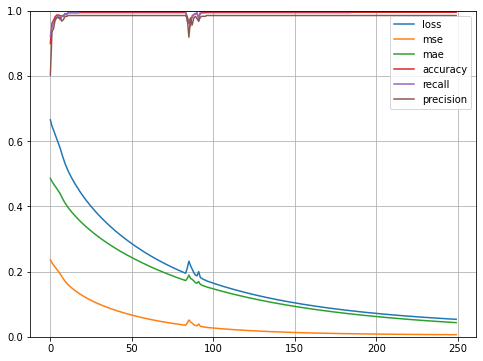

In [0]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##**9. Predecir con el modelo, la clasificación de cada imagen del conjunto de Test**

In [0]:
#SE EVALÚA EL MODELO
Xtest_MA=matriz_final_train_y_test(Xtest)
Valores=(model.predict(Xtest_MA))
#Valores

In [0]:
#Valores_label=np.argmax(Valores, axis=1)
#Valores_label
Valores_label=np.around(Valores)

##**10. Sacar métricas de evaluación, para mirar el rendimiento del modelo.**

> **A. Matriz de confusión simple.**

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score

acc = accuracy_score(Ytest,Valores_label)
print('acierto: ',acc)
cm=confusion_matrix(Ytest,Valores_label)
cm

acierto:  0.97


array([[193,   3],
       [  6,  98]])


>**B. Matriz de confusión, con porcentjes de acierto.**

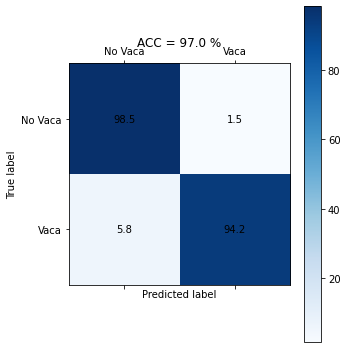

In [0]:
from sklearn.utils.multiclass import unique_labels

#FUNCION PARA PASAR LOS VALORES DE SALIDA PREDECIDOS A VALORES DE LAS 3 CLASES: VACA,CABALLO Y GALLINA
def convertir_salida_texto(Valores):
  salida=[]
  for i in range(len(Valores)):
    s="No es una vaca" if Valores[i]==0 else "Si es una vaca"
    salida.append(s)
  return salida

def plot_confusion_matrix(matrix,Ytest,Valores_label,acc,Valores2):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cmap=plt.cm.Blues
    matrix = 100*matrix.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cax = ax.matshow(matrix, interpolation='nearest', cmap=cmap)
    fig.colorbar(cax)
    classes = unique_labels(Ytest,Valores_label)
    classes1= Valores2
    ax.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=classes1, yticklabels=classes1,
           title='ACC = %.1f %%' % (100*acc),
           ylabel='True label',
           xlabel='Predicted label')
    fmt = '.1f'
    thresh = matrix.max() / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, format(matrix[i, j], fmt),
                    ha="center", va="center",
                    color="black")
    fig.tight_layout()

Valores_label_texto=convertir_salida_texto(Valores_label)
plot_confusion_matrix(cm,Ytest,Valores_label,acc,Valores2=["No Vaca","Vaca"])




> **C. Reporte de algunas métricas: Precisión, recall, F1 y Support, para el umbral de clasificación 0,5(por defecto usado por keras).**


In [0]:
from sklearn.metrics import classification_report

target_names = ['No Vaca','Vaca']
cr=classification_report(Ytest, Valores_label,labels=range(len(target_names)),target_names=target_names)
print(cr) 

              precision    recall  f1-score   support

     No Vaca       0.97      0.98      0.98       196
        Vaca       0.97      0.94      0.96       104

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



>**D. Curva ROC, para cada clase, variando los umbrales de decisión(Thresold) o, en este caso con la probabilidad de que pertenezca a una de las salidas.**

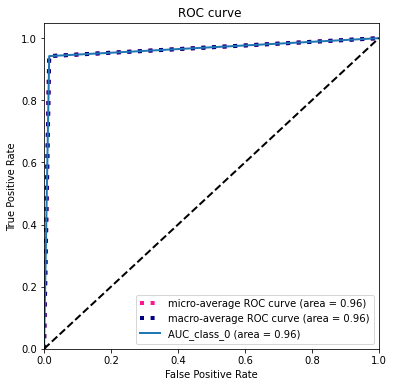

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc



Ytest_Bin= label_binarize(Ytest, classes=[0,1])
Valores_Bin= label_binarize(Valores_label, classes=[0,1])
roc_auc, fpr, tpr, n_classes = roc_multiclass(Ytest_Bin,Valores_Bin,colum=1)
roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ')



##11. Graficar imágenes de Xtest, para visualizar las predicciones.


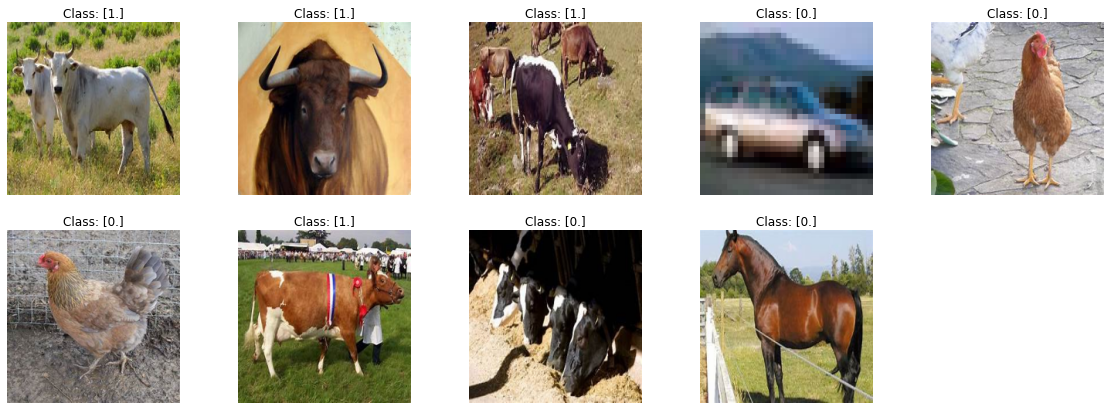

In [0]:
tam=10
index=0
plt.figure(figsize=(tam*2, 7))
for i in range(1,tam):
  index += 1
  plt.subplot((tam//10)+1, 5, index)
  plt.imshow(Xtest_MA[i+55])
  plt.title("Class: {}".format(Valores_label[i+55]))
  plt.axis("off")
plt.show() 